# Импорты необходимых библиотек

In [196]:
from typing import Tuple, Callable, List

import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns

%matplotlib inline

In [135]:
np.random.seed(73)

# Проблема

Сгенерируем данные с одинаковыми средними

In [220]:
data_fst = np.random.normal(
    loc=10,                                     # mean
    scale=10,                                   # std
    size=100,
)
data_snd = np.random.normal(10, 1, size=100)

Если мы посмотрим на средние значения выборок, то они конечно же будут различны

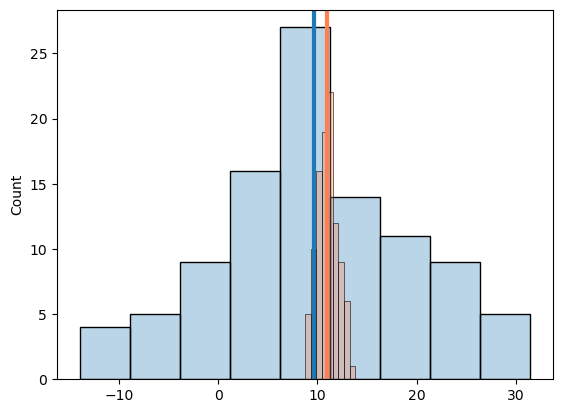

In [235]:
sns.histplot(data_fst, alpha=0.3)
sns.histplot(data_snd, color="coral", alpha=0.3)
plt.axvline(x=data_fst.mean(), linewidth=3)
plt.axvline(x=data_snd.mean(), color="coral", linewidth=3)

Но если средние выборок разные, то числа также могут не сильно отличаться

In [236]:
data_fst = np.random.normal(10, 10, size=100)
data_snd = np.random.normal(11, 1, size=100)

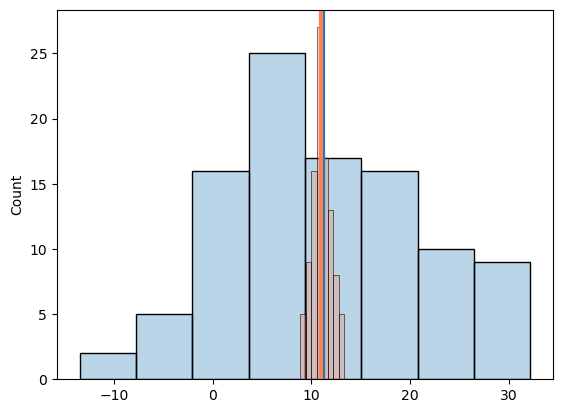

In [237]:
sns.histplot(data_fst, alpha=0.3)
sns.histplot(data_snd, color="coral", alpha=0.3)
plt.axvline(x=data_fst.mean(), linewidth=3)
plt.axvline(x=data_snd.mean(), color="coral", linewidth=3)

**Здесь появляется проблема:** как оценить средние двух выборок? Из одного они распределения или из разных?

# Использование ЦПТ

### Можно воспользоваться ЦПТ и получить доверительный интервал для среднего

#### Напоминание ЦПТ:
Пусть $\xi_1, \xi_2, \dots$ - независимые одинаково распределённые случайные величины с конечной дисперсией $D \xi_1$ и мат. ожиданием $E \xi_1$, тогда

$\sqrt{\frac{n}{D \xi_1}} \left(\frac{\sum\limits_{i=1}^{n} \xi_i}{n} - E \xi_1\right) \to_{n \to \infty} \mathcal{N}(0, 1)$ 

Отсюда можно сделать вывод, что при больших $n$ величина $\frac{\sum\limits_{i=1}^{n} \xi_i}{n}$ будет распределена примерно как $\mathcal{N}(E \xi_1, \frac{D \xi_1}{n})$

Если бы мы знали $D \xi_1$, то отсюда можно получить интервал на $E \xi_1$:
$$
P\left(E \xi_1 \in \left[\frac{\sum\limits_{i=1}^{n} \xi_i}{n} - 1.96 \sqrt{\frac{D \xi_1}{n}}, \frac{\sum\limits_{i=1}^{n} \xi_i}{n} + 1.96 \sqrt{\frac{D \xi_1}{n}}\right]\right) \approx 0.95
$$

$D \xi_1$ можно оценить по выборке

Напишем функцию для получения доверительного интервала для среднего конкретной выборки:

In [51]:
def get_95_interval(data: list, sigma: float=None) -> Tuple[float]:
    """Получение доверительного интервала для срееднего выборки

    Args:
        data (list): Выборка
        sigma (float, optional): Дисперсия генеральной совокупности. Defaults to None.

    Returns:
        Tuple[float]: Доверительный интервал вида (left_bound, right_bound)
    """
    mean = data.mean()
    if sigma is None:
        sigma = data.std()
    err = sigma * 1.96 / np.sqrt(len(data))

    return mean - err, mean + err

Напишем еще одну функцию для оценки того, что доверительный интервал действительно содержит истинное среднее выборки:

In [57]:
def get_interval_proba(
        loc: float,
        scale: float, 
        size: int, 
        use_true_sigma: bool = False, 
        iterations: int = 10000,
    ) -> float:
    """Функция для оценки вероятности того, что истинное значение среднего выборки лежит в пределах интверала из функции `get_95_interval`

    Args:
        loc (float): Среднее выборки
        scale (float): Стандартное отклонение выборки
        size (int): Размер выборки
        true_sigma (float, optional): Дисперсия генеральной совокупности. Defaults to None.
        iterations (int, optional): Количество итераций для оценки вероятности. Defaults to 10000.

    Returns:
        float: Вероятность попадания истинного значения среднего в предполагаемый интервал
    """
    hits = 0
    sigma = scale if use_true_sigma else None

    for _ in range(iterations):
        data = np.random.normal(loc, scale, size=size)
        lower_bound, upper_bound = get_95_interval(data, sigma=sigma)

        if lower_bound <= loc <= upper_bound:
            hits += 1
    
    return hits / iterations

Теперь проверим корректность получаемых интервалов:

In [58]:
get_interval_proba(loc=10, scale=10, size=100)

0.9487

Однако, если данных мало, то оценка неправильна

In [59]:
get_interval_proba(10, 10, size=10)

0.9016

Подставим реальное значение дисперсии и всё снова заработает

In [60]:
get_interval_proba(10, 10, 10, use_true_sigma=True)

0.9503

Итак, у нас две выборки с гигантской разницей в среднем

In [39]:
data_fst = np.random.normal(10.5, 10, size=100)
data_snd = np.random.normal(100, 1, size=100)

print(get_95_interval(data_fst))
print(get_95_interval(data_snd))

(9.02278704552332, 13.441653928894379)
(99.74272844774913, 100.13803493726721)


Конечно же интервалы не пересекаются

Однако, если разница небольшая, то интервалы могут пересечься:

(5.0, 15.0)

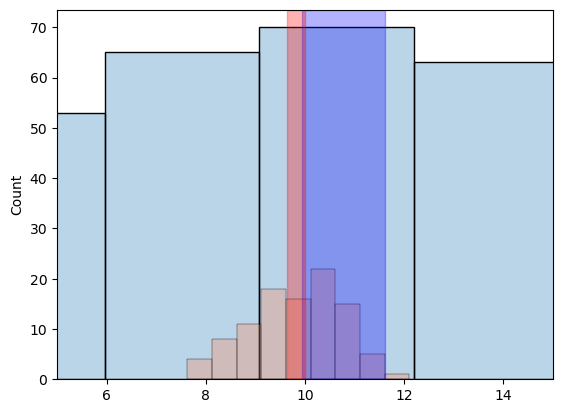

In [136]:
"""Повторите эту ячейку несколько раз, пока не убидеитесь в том, что интервалы действительно могут пересечься"""

data_fst = np.random.normal(11, 10, size=500)
data_snd = np.random.normal(10, 1, size=100)

interval_fst = get_95_interval(data_fst)
interval_snd = get_95_interval(data_snd)

sns.histplot(data_fst, alpha=0.3)
sns.histplot(data_snd, color="coral", alpha=0.3)

plt.axvspan(*interval_fst, alpha=0.3, color='blue')
plt.axvspan(*interval_snd, alpha=0.3, color='red')

plt.xlim(right=15, left=5)

Напишем функцию, которая будет оценивать корректность некоторого теста:

In [144]:
def get_test_power(
        test: Callable,
        data_fst_params: Tuple[float, float, int],
        data_snd_params: Tuple[float, float, int],
        iterations: int = 10000,
    ) -> float:
        """Оценка вероятности того, что некоторый тест срабатывает корректно

        Args:
            test (Callable): Наш тест, который ена вход принимает две выборки
            data_fst_params (Tuple[float, float, int]): Параметры для первой выборки (среднее, отклонение, размер выборки)
            data_snd_params (Tuple[float, float, int]): Параметры для второй выборки (среднее, отклонение, размер выборки)
            iterations (int, optional): Количество итераций для оценки вероятности. Defaults to 10000.

        Returns:
            float: Оценка вероятности
        """
        hits = 0

        for _ in range(iterations):
            data_fst = np.random.normal(*data_fst_params)
            data_snd = np.random.normal(*data_snd_params)

            hits += test(data_fst, data_snd)

        return hits / iterations


Теперь напишем функцию "критерия интервалов", где мы смотрим на то, пересеклись ли интервалы средних двух выборок или нет:

In [145]:
def check_interval_intersection(data_fst: np.ndarray, data_snd: np.ndarray) -> bool:
    lower_fst, upper_fst = get_95_interval(data_fst)
    lower_snd, upper_snd = get_95_interval(data_snd)
    
    if not (lower_fst <= lower_snd <= upper_fst or lower_fst <= upper_snd <= upper_fst):
        return True

    return False

Давайте посмотрим, как часто такой критерий (доверительные интервалы не пересекаются) будет находить различие в случае, если оно есть. В некотором смысле это мощность критерия.

In [147]:
get_test_power(
    check_interval_intersection,
    data_fst_params=(11, 10, 1000),
    data_snd_params=(10, 1, 100),
)

0.7107

Также проверим, как часто различие будет обнаруживаться, если его нет

In [149]:
get_test_power(
    check_interval_intersection,
    data_fst_params=(10, 10, 1000),
    data_snd_params=(10, 1, 100),
)

0.0131

Также проверим, как часто различие будет обнаруживаться, если оно есть, но очень маленькое

In [150]:
get_test_power(
    check_interval_intersection,
    data_fst_params=(10.1, 10, 1000),
    data_snd_params=(10, 1, 100),
)

0.0189

У нас очень маленькая ошибка первого рода (правда мы хотели 0.05), но мощность тоже небольшая

**Вывод**: этот способ очень прост, но можно использовать более мощные и подконтрольные критерии

В простом варианте давайте вычтем две незавимых случайных величины друг из друга

$\mathcal{N}(a_1, \sigma_1^2) - \mathcal{N}(a_2, \sigma_2^2) \sim \mathcal{N}(a_1 - a_2, \sigma_1^2 + \sigma_2^2)$ 

То есть в нашем случае $\frac{\sum\limits_{i=1}^{n^1} \xi_i^1}{n^1} - \frac{\sum\limits_{i=1}^{n^2} \xi_i^2}{n^2}$ будет распределена примерно как $\mathcal{N}(E \xi_1^1 - E \xi_1^2, \frac{D \xi_1^1}{n^1} + \frac{D \xi_1^2}{n^2})$

Проверим те же параметры, что и в предыдущем случае

In [243]:
def check_(data_fst: np.ndarray, data_snd: np.ndarray) -> bool:                             # TODO: нужно адекватное название функции
    mean_diff = data_fst.mean() - data_snd.mean()
    std_sum = data_fst.std() ** 2 / len(data_fst) + data_snd.std() ** 2 / len(data_snd)
    
    stat = mean_diff / np.sqrt(std_sum)

    if abs(stat) > 1.96:
        return True
    return False

In [244]:
get_test_power(
    check_,
    data_fst_params=(11, 10, 1000),
    data_snd_params=(10, 1, 100),
)

0.8543

In [245]:
get_test_power(
    check_,
    data_fst_params=(10, 10, 1000),
    data_snd_params=(10, 1, 100),
)

0.0485

In [246]:
get_test_power(
    check_,
    data_fst_params=(10.1, 10, 1000),
    data_snd_params=(10, 1, 100),
)

0.0623

Это уже более похоже на то, чего нам бы хотелось

# SciPy tests

Каждый раз писать такие критерии было чересчур, тем более в модуле scipy всё уже есть

Например, в scipy есть куча различных тестов, в которых уже все формулы написаны и надо просто вызвать функцию

In [164]:
data_fst = np.random.normal(10, 10, size=100)
data_snd = np.random.normal(11, 1, size=100)

In [165]:
scipy.stats.ttest_ind(data_fst, data_snd).pvalue

0.09778014613937475

Напишем функцию для оценки T-test'а из пакет scipy:

In [252]:
def check_ttest_pval(data_fst: np.ndarray, data_snd: np.ndarray) -> bool:
    if scipy.stats.ttest_ind(data_fst, data_snd).pvalue < 0.05:
        return True
    return False

In [253]:
get_test_power(
    check_ttest_pval,
    data_fst_params=(11, 10, 1000),
    data_snd_params=(10, 1, 100),
)

0.0023

In [254]:
get_test_power(
    check_ttest_pval,
    data_fst_params=(10, 10, 1000),
    data_snd_params=(10, 1, 100),
)

0.0

сломалось(

Исправим вызов теста в нашей фукнкции оценки:

In [255]:
def check_ttest_pval(data_fst: np.ndarray, data_snd: np.ndarray) -> bool:
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        return True
    return False

In [256]:
get_test_power(
    check_ttest_pval,
    data_fst_params=(11, 10, 1000),
    data_snd_params=(10, 1, 100),
)

0.8556

In [257]:
get_test_power(
    check_ttest_pval,
    data_fst_params=(10, 10, 1000),
    data_snd_params=(10, 1, 100),
)

0.0469

Примерно как и ЦПТ, только не надо париться с формулами

Давайте попробуем другой тест.

Например, Мана-Уитни:

In [258]:
def check_mannwhitneyu_pval(data_fst: np.ndarray, data_snd: np.ndarray) -> bool:
    if scipy.stats.mannwhitneyu(data_fst, data_snd, alternative='two-sided').pvalue < 0.05:
        return True
    return False

In [259]:
get_test_power(
    check_mannwhitneyu_pval,
    data_fst_params=(11, 10, 1000),
    data_snd_params=(10, 1, 100),
)

0.1046

In [260]:
get_test_power(
    check_mannwhitneyu_pval,
    data_fst_params=(10, 10, 1000),
    data_snd_params=(10, 1, 100),
)

0.0002

In [184]:
get_test_power(
    check_mannwhitneyu_pval,
    data_fst_params=(0, 10, 1000),
    data_snd_params=(0, 1, 100),
)

0.0006

Думаете всё сломалось? Нет, просто у этого критерия другая нулевая гипотеза!

In [186]:
get_test_power(
    check_mannwhitneyu_pval,
    data_fst_params=(0, 1, 1000),
    data_snd_params=(0, 1, 100),
)

0.0522

In [188]:
get_test_power(
    check_mannwhitneyu_pval,
    data_fst_params=(0, 1, 1000),
    data_snd_params=(1, 1, 100),
)

1.0

# О смысле p-value, корректности и мощности

In [202]:
def get_pvalues_ttest(
        data_fst_params: Tuple[float, float, int],
        data_snd_params: Tuple[float, float, int],
        iterations: int = 10000,
    ) -> List[float]:
    pvalues = []
    for _ in range(iterations):
        data_fst = np.random.normal(*data_fst_params)
        data_snd = np.random.normal(*data_snd_params)
        pvalues.append(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
        
    return np.array(pvalues)

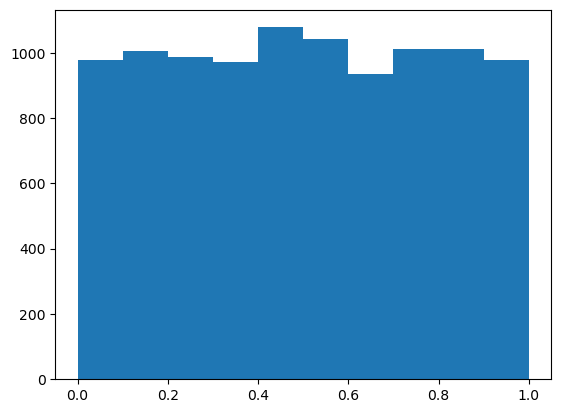

In [203]:
pvalues = get_pvalues_ttest(
    data_fst_params=(10, 10, 100),
    data_snd_params=(10, 1, 100),
)
    
plt.hist(pvalues)
plt.show()

Корректность критерия

In [214]:
pvalues = get_pvalues_ttest(
    data_fst_params=(10, 10, 100),
    data_snd_params=(10, 1, 100),
)
    
print(np.mean(pvalues[pvalues < 0.05]))

0.024191509854355083


In [217]:
bad_pvalues = []
for _ in range(10000):
    data_fst = np.random.normal(10, 10, size=100)
    data_snd = np.random.normal(10, 1, size=100)
    bad_pvalues.append(scipy.stats.ttest_ind(data_fst, data_snd).pvalue < 0.05)
    
print(np.mean(bad_pvalues))

0.0576


Мощность критерия

0.1708


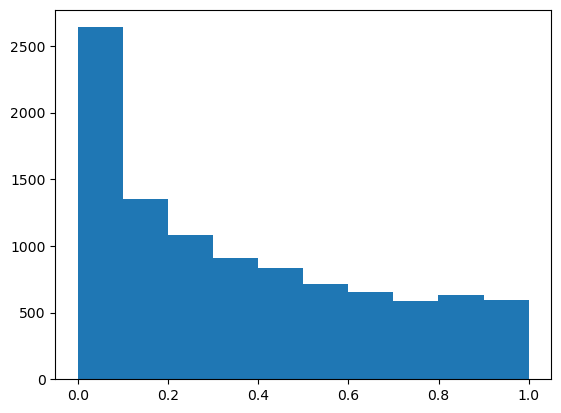

In [192]:
pvalues = []
for _ in range(10000):
    data_fst = np.random.normal(11, 10, size=100)
    data_snd = np.random.normal(10, 1, size=100)
    pvalues.append(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
    
print((np.array(pvalues) < 0.05).mean())
plt.hist(pvalues)
plt.show()

Усилим различие

0.505


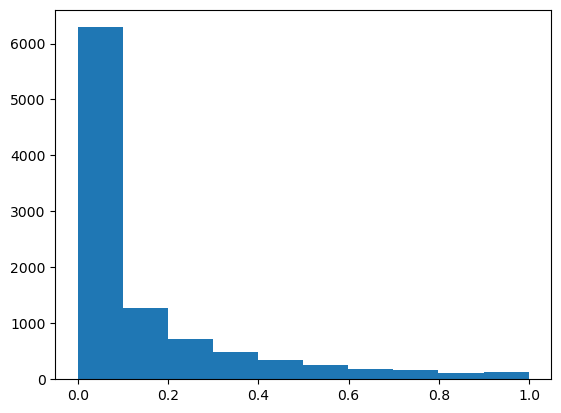

In [193]:
pvalues = []
for _ in range(10000):
    data_fst = np.random.normal(12, 10, size=100)
    data_snd = np.random.normal(10, 1, size=100)
    pvalues.append(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
    
print((np.array(pvalues) < 0.05).mean())
plt.hist(pvalues)
plt.show()

Увеличим выборку

0.8843


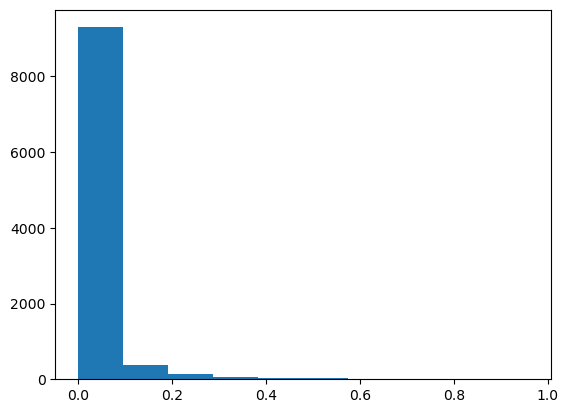

In [194]:
pvalues = []
for _ in range(10000):
    data_fst = np.random.normal(11, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=1000)
    pvalues.append(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
    
print((np.array(pvalues) < 0.05).mean())
plt.hist(pvalues)
plt.show()

# Перестановочные тесты

In [ ]:
def my_test(data_fst, data_snd, iters=1000, plot=True):
    data = np.array(list(data_fst) + list(data_snd))
    size = len(data)
    values = []
    fst_ratio = len(data_fst) * 1. / size
    for _ in range(iters):
        mask = (np.random.random(size=size) < fst_ratio)
        values.append(data[mask].mean() - data[~mask].mean())
        
    if plot:
        plt.hist(values, bins=30)
        plt.show()
        
    return (np.abs(values) > np.abs(data_fst.mean() - data_snd.mean())).mean()

### Корректно ли такое применение?

In [ ]:
data_fst = np.random.normal(0, 10, size=100)
data_snd = np.random.normal(0, 1, size=100)

print(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
print(my_test(data_fst, data_snd, iters=10))
print(my_test(data_fst, data_snd, iters=100))
print(my_test(data_fst, data_snd, iters=1000))
print(my_test(data_fst, data_snd, iters=10000))

In [ ]:
data_fst = np.random.normal(0, 10, size=100)
data_snd = np.random.normal(1, 1, size=100)

print(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
print(my_test(data_fst, data_snd, iters=10))
print(my_test(data_fst, data_snd, iters=100))
print(my_test(data_fst, data_snd, iters=1000))
print(my_test(data_fst, data_snd, iters=10000))

К сожалению нет :(

Давайте в этом убедимся :(

In [ ]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(11, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if my_test(data_fst, data_snd, plot=False, iters=1000) < 0.05:
        hits += 1

print(hits / count)

In [ ]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(10, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if my_test(data_fst, data_snd, plot=False, iters=1000) < 0.05:
        hits += 1

print(hits / count)

Как с Мана-Уитни, нулевая гипотеза это что распределения совпадают

In [ ]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(11, 1, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if my_test(data_fst, data_snd, plot=False, iters=1000) < 0.05:
        hits += 1

print(hits / count)

In [ ]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(10, 1, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    count += 1
    if my_test(data_fst, data_snd, plot=False, iters=1000) < 0.05:
        hits += 1

print(hits / count)

Вот это уже неплохо

# Bootstrap

In [ ]:
def my_bootstrap(data_fst, data_snd, iters=1000, plot=True):
    values = []
    for _ in range(iters):
        values.append(
            np.random.choice(data_fst, replace=True, size=len(data_fst)).mean()
            -
            np.random.choice(data_snd, replace=True, size=len(data_snd)).mean()
        )
        
    if plot:
        plt.hist(values, bins=30)
        plt.show()
        
    return np.percentile(values, [2.5, 97.5])

In [ ]:
data_fst = np.random.normal(0, 10, size=1000)
data_snd = np.random.normal(0, 1, size=100)

print(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
print(my_bootstrap(data_fst, data_snd, iters=1000, plot=True))

In [ ]:
data_fst = np.random.normal(1, 10, size=1000)
data_snd = np.random.normal(0, 1, size=100)

print(scipy.stats.ttest_ind(data_fst, data_snd).pvalue)
print(my_bootstrap(data_fst, data_snd, iters=1000, plot=True))

In [ ]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(11, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    lower, upper = my_bootstrap(data_fst, data_snd, plot=False, iters=1000)
    count += 1
    if not (lower < 0 < upper):
        hits += 1

print(hits / count)

In [ ]:
hits = 0.
count = 0.

for _ in range(1000):
    data_fst = np.random.normal(10, 10, size=1000)
    data_snd = np.random.normal(10, 1, size=100)

    lower, upper = my_bootstrap(data_fst, data_snd, plot=False, iters=1000)
    count += 1
    if not (lower < 0 < upper):
        hits += 1

print(hits / count)

# Бакетное сэмплирование

In [ ]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10, 5, size=10000)
    data_snd = np.random.normal(10, 1, size=10000)
    
    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(hits / count)

In [ ]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10.1, 5, size=10000)
    data_snd = np.random.normal(10, 1, size=10000)
    
    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(hits / count)

делаем бакеты

In [ ]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10, 5, size=10000).reshape((100, 100)).mean(axis=1)
    data_snd = np.random.normal(10, 1, size=10000).reshape((100, 100)).mean(axis=1)
    
    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(hits / count)

In [ ]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10.1, 5, size=10000).reshape((100, 100)).mean(axis=1)
    data_snd = np.random.normal(10, 1, size=10000).reshape((100, 100)).mean(axis=1)
    
    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(hits / count)

Можно и суммы

In [ ]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10, 5, size=10000).reshape((100, 100)).sum(axis=1)
    data_snd = np.random.normal(10, 1, size=10000).reshape((100, 100)).sum(axis=1)
    
    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(hits / count)

In [ ]:
hits = 0.
count = 0.

for _ in range(10000):
    data_fst = np.random.normal(10.1, 5, size=10000).reshape((100, 100)).sum(axis=1)
    data_snd = np.random.normal(10, 1, size=10000).reshape((100, 100)).sum(axis=1)
    
    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(hits / count)

А теперь усложним выборку

In [ ]:
hits = 0.
count = 0.

for _ in range(10000):
    params_fst = np.random.uniform(-5, 5, size=1000)
    params_snd = np.random.uniform(-5, 5, size=1000)
    
    data_fst = np.random.normal(10, 5, size=10000).reshape((1000, 10)) + params_fst[:, np.newaxis]
    data_fst = data_fst.reshape((10000,))
    data_snd = np.random.normal(10, 1, size=10000).reshape((1000, 10)) + params_snd[:, np.newaxis]
    data_snd = data_snd.reshape((10000,))
    
    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(hits / count)

In [ ]:
hits = 0.
count = 0.

for _ in range(10000):
    params_fst = np.random.uniform(-1, 1, size=1000)
    params_snd = np.random.uniform(-1, 1, size=1000)
    
    data_fst = np.random.normal(10.1, 5, size=10000).reshape((1000, 10)) + params_fst[:, np.newaxis]
    data_fst = data_fst.reshape((10000,))
    data_snd = np.random.normal(10, 1, size=10000).reshape((1000, 10)) + params_snd[:, np.newaxis]
    data_snd = data_snd.reshape((10000,))
    
    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(hits / count)

беда(

In [ ]:
hits = 0.
count = 0.

for _ in range(10000):
    params_fst = np.random.uniform(-5, 5, size=1000)
    params_snd = np.random.uniform(-5, 5, size=1000)
    
    data_fst = np.random.normal(10, 5, size=10000).reshape((1000, 10)) + params_fst[:, np.newaxis]
    data_fst = data_fst.reshape((10000,)).reshape((100, 100)).mean(axis=1)
    data_snd = np.random.normal(10, 1, size=10000).reshape((1000, 10)) + params_snd[:, np.newaxis]
    data_snd = data_snd.reshape((10000,)).reshape((100, 100)).mean(axis=1)
    
    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(hits / count)

In [ ]:
hits = 0.
count = 0.

for _ in range(10000):
    params_fst = np.random.uniform(-5, 5, size=1000)
    params_snd = np.random.uniform(-5, 5, size=1000)
    
    data_fst = np.random.normal(10.1, 5, size=10000).reshape((1000, 10)) + params_fst[:, np.newaxis]
    data_fst = data_fst.reshape((10000,)).reshape((100, 100)).mean(axis=1)
    data_snd = np.random.normal(10, 1, size=10000).reshape((1000, 10)) + params_snd[:, np.newaxis]
    data_snd = data_snd.reshape((10000,)).reshape((100, 100)).mean(axis=1)
    
    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(hits / count)

In [ ]:
hits = 0.
count = 0.

for _ in range(10000):
    params_fst = np.random.uniform(-1, 1, size=1000)
    params_snd = np.random.uniform(-1, 1, size=1000)
    
    data_fst = np.random.normal(10.1, 5, size=10000).reshape((1000, 10)) + params_fst[:, np.newaxis]
    data_fst = data_fst.reshape((10000,)).reshape((100, 100)).mean(axis=1)
    data_snd = np.random.normal(10, 1, size=10000).reshape((1000, 10)) + params_snd[:, np.newaxis]
    data_snd = data_snd.reshape((10000,)).reshape((100, 100)).mean(axis=1)
    
    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(hits / count)

In [ ]:
hits = 0.
count = 0.

for _ in range(10000):
    params_fst = np.random.uniform(-10, 10, size=1000)
    params_snd = np.random.uniform(-10, 10, size=1000)
    
    data_fst = np.random.normal(11, 5, size=10000).reshape((1000, 10)) + params_fst[:, np.newaxis]
    data_fst = data_fst.reshape((10000,)).reshape((100, 100)).mean(axis=1)
    data_snd = np.random.normal(10, 1, size=10000).reshape((1000, 10)) + params_snd[:, np.newaxis]
    data_snd = data_snd.reshape((10000,)).reshape((100, 100)).mean(axis=1)
    
    count += 1
    if scipy.stats.ttest_ind(data_fst, data_snd, equal_var=False).pvalue < 0.05:
        hits += 1

print(hits / count)